# Projet P6 - Classifiez automatiquement des biens de consommation
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 05/2024*
<hr>

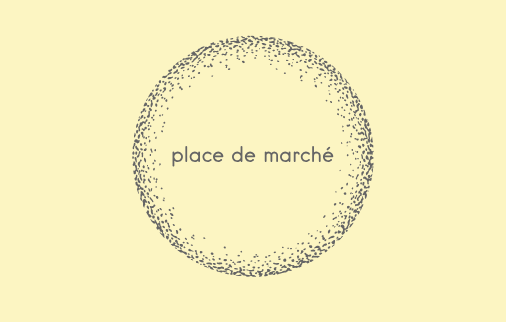

## <font color='#46abe6'>Contexte</font>
Place de marché est un site de e-commerce où des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
 
Actuellement, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.
 
L'objectif de ce projet est d'étudier la faisablité d'un moteur de classification à partir de la description textuelle ou de l'image du produit.

## <font color='#46abe6'>Sommaire</font>

<span style='background:#46abe6'><span style='color:white'>**Partie 1 - Données textuelles - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 2 - Données textuelles - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 3 - Images - Analyse exploratoire des données**</span></span>

<span style='background:#d5155b'><span style='color:white'>**Partie 4 - Images - Feature extraction et faisabilité**</span></span>

[Importation des librairies + fonctions + données](#1)
* [Importation des librairies](#1_1)
* [Fonctions](#1_2)
* [Importation des données](#1_3)

[VGG16](#2)
* [Création du modèle pré-entraîné](#2_1)
* [Images couleurs](#2_2)
* [Images nuances de gris](#2_3)

[DenseNet](#3)
* [Création du modèle pré-entraîné](#3_1)
* [Images couleurs](#3_2)
* [Images nuances de gris](#3_3)

[MobileNetV3](#4)
* [Création du modèle pré-entraîné](#4_1)
* [Features extraction](#4_2)
* [Réduction de dimensions par PCA](#4_3)


<span style='background:#46abe6'><span style='color:white'>**Partie 5 - Images - Classification**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 6 - Images - Requête API**</span></span>

# <font color='#0a389f'>Importation librairies + fonctions<a class="anchor" id="1"></a></font>

## <font color='#46abe6'>Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

import os
import time
import pickle
from tqdm import tqdm

from sklearn import decomposition

import cv2

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.4
pandas - 2.2.2
cv2 - 4.10.0
tensorflow - 2.16.1


## <font color='#46abe6'>Fonctions<a class="anchor" id="1_2"></a></font>

In [9]:
def process_image(img_file):
    """!
    @brief Prétraite une image et génère des prédictions à partir d'un modèle de deep learning.

    Cette fonction charge une image, la redimensionne, la convertit en tableau numpy, applique un prétraitement
    spécifique au modèle, puis passe l'image à travers un modèle pour obtenir des prédictions.

    @param img_file: Nom du fichier de l'image à traiter (str).
    @return np.ndarray: Les prédictions du modèle pour l'image (np.ndarray).
    """
    img_path = os.path.join(path, img_file)
    img = load_img(img_path, target_size=(224, 224))   
    img = img_to_array(img) 
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return model.predict(img, verbose=0)[0]

In [10]:
def process_image_gray(img_file):
    """!
    @brief Prétraite une image en niveaux de gris et génère des prédictions à partir d'un modèle de deep learning.

    Cette fonction charge une image en niveaux de gris, améliore son contraste, la convertit en format RGB,
    et génère des prédictions en utilisant un modèle de deep learning.

    @param img_file: Nom du fichier de l'image à traiter (str).
    @return np.ndarray: Les prédictions du modèle pour l'image (np.ndarray).
    """
    img_path = os.path.join(path, img_file)
    img = load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.astype(np.uint8)
    contrast_img = cv2.equalizeHist(img_array[:, :, 0]) # Améliorer le contraste de l'image
    img_rgb = np.stack([contrast_img] * 3, axis=-1)# répéter le canal unique pour obtenir une image RGB
    img_rgb = np.expand_dims(img_rgb, axis=0)# Ajouter une dimension supplémentaire pour le batch
    img_rgb = preprocess_input(img_rgb)
    return model.predict(img_rgb, verbose=0)

In [11]:
def reduce_and_export_features(img_features, output_file):
    """!
    @brief Réduit les dimensions d'un ensemble de caractéristiques à l'aide de la PCA et exporte les caractéristiques
    réduites dans un fichier.

    Cette fonction applique la réduction de dimension PCA sur les caractéristiques d'images, en conservant 99% de la 
    variance, puis exporte les caractéristiques réduites dans un fichier spécifié.

    @param img_features: Matrice des caractéristiques des images avant réduction (np.ndarray).
    @param output_file: Nom du fichier pour exporter les caractéristiques réduites (str).
    """
    print("Dimensions dataset avant réduction PCA : ", img_features.shape)
    # Appliquer la PCA pour réduire les dimensions
    pca = decomposition.PCA(n_components=0.99)
    feat_pca = pca.fit_transform(img_features)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    # Exporter les caractéristiques réduites
    with open(output_file, 'wb') as file:
        pickle.dump(feat_pca, file) 
    print(f"Features après réduction de dimensions sauvegardées sous {output_file}")

## <font color='#46abe6'>Importation des données<a class="anchor" id="1_3"></a></font>

In [12]:
# Chemin du répertoire des images et liste des noms des images
path = 'C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/Dataset+projet+prétraitement+textes+images/Flipkart/Images/'
list_images = [file for file in os.listdir(path)]

# <font color='#0a389f'>VGG16<a class="anchor" id="2"></a></font>

## <font color='#46abe6'>Création du modèle pré-entraîné<a class="anchor" id="3_1"></a></font>

In [16]:
# Importation du modèle
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Modèle final pour l'extraction de features.
model = Model(inputs=base_model.inputs, outputs=x)

print(model.summary())

Le modèle a 19 couches.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


## <font color='#46abe6'>Images sans pré-traitement<a class="anchor" id="3_2"></a></font>

* **Features extraction**

In [15]:
img_features = []
temps1=time.time()

for img_file in tqdm(list_images):
    img_features.append(process_image(img_file))

    # Conversion en array    
img_features = np.asarray(img_features)

print("Nombre de features : ", img_features.shape)
duration1=time.time()-temps1
print("Temps de traitement : ", "%15.2f" % duration1, "secondes")

 32%|███▏      | 338/1050 [02:02<04:06,  2.89it/s]C:\Users\Adeline\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [06:22<00:00,  2.74it/s]

Nombre de features :  (1050, 512)
Temps de traitement :           382.56 secondes


* **Réduction de dimensions par PCA**
    * La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
    * L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [19]:
# Réduction de dimensions PCA et Exportation des features extraites
reduce_and_export_features(img_features, 'features_vgg16.pkl')

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 351)
Features après réduction de dimensions sauvegardées sous features_vgg16.pkl


## <font color='#46abe6'>Images avec pré-traitement<a class="anchor" id="2_3"></a></font>

* **Features extraction**

In [12]:
img_features = []
temps1=time.time()

for img_file in tqdm(list_images):
    img_features.append(process_image_gray(img_file))

# Conversion en array    
img_features = np.asarray(img_features)
img_features = img_features.reshape(img_features.shape[0], -1)

print("Nombre de features : ", img_features.shape)
duration1=time.time()-temps1
print("Temps de traitement : ", "%15.2f" % duration1, "secondes")

 32%|███▏      | 338/1050 [01:05<02:30,  4.73it/s]C:\Users\Adeline\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [03:29<00:00,  5.02it/s]

Nombre de features :  (1050, 4096)
Temps de traitement :           209.17 secondes


* **Réduction de dimensions par PCA**
    * La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
    * L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [13]:
# Réduction de dimensions PCA et Exportation des features extraites
reduce_and_export_features(img_features, 'features_VGG16_gray.pkl')

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 812)
Features après réduction de dimensions sauvegardées sous features_VGG16_gray.pkl


# <font color='#0a389f'>DenseNet<a class="anchor" id="3"></a></font>

## <font color='#46abe6'>Création du modèle pré-entraîné<a class="anchor" id="3_1"></a></font>

In [17]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

base_model = DenseNet201(weights='imagenet', include_top = False)
# Obtenir le nombre de couches
nombre_de_couches = len(base_model.layers)
print(f"Le modèle a {nombre_de_couches} couches.")
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Modèle final pour l'extraction de features.
model = Model(inputs=base_model.inputs, outputs=x)

print(model.summary())

Le modèle a 707 couches.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

None


## <font color='#46abe6'>Images sans pré-traitement<a class="anchor" id="3_2"></a></font>

* **Features extraction**

In [25]:
img_features = []
temps1=time.time()

for img_file in tqdm(list_images):
    img_features.append(process_image(img_file))

# Conversion en array    
img_features = np.asarray(img_features)
img_features = img_features.reshape(img_features.shape[0], -1)

print("Nombre de features : ", img_features.shape)
duration1=time.time()-temps1
print("Temps de traitement : ", "%15.2f" % duration1, "secondes")

 32%|███▏      | 338/1050 [00:57<01:47,  6.65it/s]C:\Users\Adeline\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [02:50<00:00,  6.16it/s]

Nombre de features :  (1050, 1920)
Temps de traitement :           170.53 secondes


* **Réduction de dimensions par PCA**
    * La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
    * L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [26]:
# Réduction de dimensions PCA et Exportation des features extraites
reduce_and_export_features(img_features, 'features_DenseNet.pkl')

Dimensions dataset avant réduction PCA :  (1050, 1920)
Dimensions dataset après réduction PCA :  (1050, 568)
Features après réduction de dimensions sauvegardées sous features_DenseNet.pkl


## <font color='#46abe6'>Images avec pré-traitement<a class="anchor" id="3_3"></a></font>

* **Features extraction**

In [27]:
img_features = []
temps1=time.time()

for img_file in tqdm(list_images):
    img_features.append(process_image_gray(img_file))

# Conversion en array    
img_features = np.asarray(img_features)
img_features = img_features.reshape(img_features.shape[0], -1)

print("Nombre de features : ", img_features.shape)
duration1=time.time()-temps1
print("Temps de traitement : ", "%15.2f" % duration1, "secondes")

 32%|███▏      | 338/1050 [00:54<01:45,  6.73it/s]C:\Users\Adeline\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [02:45<00:00,  6.33it/s]

Nombre de features :  (1050, 1920)
Temps de traitement :           165.97 secondes


* **Réduction de dimensions par PCA**
    * La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
    * L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [18]:
# Réduction de dimensions PCA et Exportation des features extraites
reduce_and_export_features(img_features, 'features_DenseNet_gray.pkl')

Dimensions dataset avant réduction PCA :  (1050, 1920)
Dimensions dataset après réduction PCA :  (1050, 554)
Features après réduction de dimensions sauvegardées sous features_DenseNet_gray.pkl


# <font color='#0a389f'>MobileNetV3<a class="anchor" id="4"></a></font>

## <font color='#46abe6'>Création du modèle pré-entraîné<a class="anchor" id="4_1"></a></font>

In [18]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Charger le modèle MobileNetV3Large pré-entraîné sans les couches de classification finales
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Obtenir le nombre de couches
nombre_de_couches = len(base_model.layers)
print(f"Le modèle a {nombre_de_couches} couches.")
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Modèle final pour l'extraction de features.
model = Model(inputs=base_model.inputs, outputs=x)

print(model.summary())

Le modèle a 187 couches.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

None


## <font color='#46abe6'>Images sans pré-traitement<a class="anchor" id="4_2"></a></font>

* **Features extraction**

In [16]:
img_features = []
temps1=time.time()

for img_file in tqdm(list_images):
    img_features.append(process_image(img_file))

# Conversion en array    
img_features = np.asarray(img_features)

print("Nombre de features : ", img_features.shape)
duration1=time.time()-temps1
print("Temps de traitement : ", "%15.2f" % duration1, "secondes")

 32%|███▏      | 337/1050 [00:26<00:49, 14.31it/s]C:\Users\Adeline\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [01:22<00:00, 12.77it/s]

Nombre de features :  (1050, 960)
Temps de traitement :            82.25 secondes


* **Réduction de dimensions par PCA**
    * La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
    * L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [17]:
# Réduction de dimensions PCA et Exportation des features extraites
reduce_and_export_features(img_features, 'features_MobileNet.pkl')

Dimensions dataset avant réduction PCA :  (1050, 960)
Dimensions dataset après réduction PCA :  (1050, 551)
Features après réduction de dimensions sauvegardées sous features_MobileNet.pkl


## <font color='#46abe6'>Images avec pré-traitement<a class="anchor" id="4_3"></a></font>

* **Features extraction**

In [22]:
img_features = []
temps1=time.time()

for img_file in tqdm(list_images):
    img_features.append(process_image_gray(img_file).flatten())

# Conversion en array    
img_features = np.asarray(img_features)

print("Nombre de features : ", img_features.shape)
duration1=time.time()-temps1
print("Temps de traitement : ", "%15.2f" % duration1, "secondes")

100%|██████████| 1050/1050 [01:17<00:00, 13.58it/s]

Nombre de features :  (1050, 960)
Temps de traitement :            77.32 secondes


* **Réduction de dimensions par PCA**
    * La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
    * L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [23]:
# Réduction de dimensions PCA et Exportation des features extraites
reduce_and_export_features(img_features, 'features_MobileNet_gray.pkl')

Dimensions dataset avant réduction PCA :  (1050, 960)
Dimensions dataset après réduction PCA :  (1050, 533)
Features après réduction de dimensions sauvegardées sous features_MobileNet_gray.pkl
